In [1]:
import sys

sys.path.append("..")
import jabble.model
import jabble.dataset
import jabble.loss
import jabble.physics 
import astropy.units as u

import h5py
import matplotlib.pyplot as plt
import scipy.optimize

from jaxopt import GaussNewton
import jax.numpy as jnp
import jax
import numpy as np
from mpl_axes_aligner import align

import os
import jabble.physics

import jax.config

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


AttributeError: cannot access submodule 'model' of module 'jabble' (most likely due to a circular import)

In [ ]:
# import jax.numpy as jnp 
# from jax import random, pmap 
# import numpy as np
# import jax
# # Ensure that JAX uses CPU devices
# # from jax.config import config
# # config.update("jax_platform_name", "срu")
# # Example function to be parallelized: compute the square of each element
# def square(x):
#     x = list(x)
#     return x ** 2
# # Generate random data
# key = random.PRNGKey(0)
# size = 10000 # size of the input array
# num_devices = jax.local_device_count() # get the number of available CPU cores
# # Split data into chunks for each device
# data = random.normal(key, (num_devices, size // num_devices) )
# # Apply the 'pmap' to parallelize the 'square' function
# squared_data = pmap(square)(data)
# # Print results
# print("Original data:", data)
# print("Squared data:", squared_data)

In [ ]:
# data.shape

In [4]:
import os
import datetime

today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [5]:
file_b = h5py.File("../data/barnards_e2ds.hdf5", "r")
file_p = h5py.File("../data/51peg_e2ds.hdf5"   , "r")

In [6]:
file_b['data'].shape

(72, 306, 4096)

In [7]:
jax.print_environment_info()

jax:    0.4.23
jaxlib: 0.4.23
numpy:  1.24.3
python: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
jax.devices (1 total, 1 local): [cuda(id=0)]
process_count: 1

$ nvidia-smi
Tue May 28 17:44:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                On  | 00000000:86:00.0 Off |                    0 |
| N/A   31C    P0              55W / 250W

In [8]:
file_b['data'].shape, file_b['bervs'].shape

((72, 306, 4096), (306,))

In [9]:
import inspect
lines = inspect.getsource(jabble.dataset.DataFrame.to_device)
print(lines)

    def to_device(self,device):
        self.xs = jax.device_put(jnp.array(self.xs),device)
        self.ys = jax.device_put(jnp.array(self.ys),device)
        self.yivar = jax.device_put(jnp.array(self.yivar),device)
        self.mask = jax.device_put(jnp.array(self.mask),device)



In [10]:
help(jabble.dataset.Data.to_device)

Help on function to_device in module jabble.dataset:

to_device(self, device)



In [11]:
def get_dataset(file,orders,device):
    ys = []
    xs = []
    yivar = []
    mask = []

    init_shifts = []
    airmass = []
    
    for iii in orders:
        for jjj in range(file["data"].shape[1]):
            ys.append(jnp.array(file["data"][iii,jjj,:]))
            xs.append(jnp.array(file["xs"][iii,jjj,:]))
            yivar.append(jnp.array(file["ivars"][iii,jjj,:]))
            mask.append(jnp.zeros(file["data"][iii,jjj,:].shape,dtype=bool))
            init_shifts.append(jabble.physics.shifts(file["bervs"][jjj]))
            airmass.append(file["airms"][jjj])
    
    init_shifts = jnp.array(init_shifts)
    airmass = jnp.array(airmass)
                         
    dataset = jabble.dataset.Data.from_lists(xs,ys,yivar,mask)
    dataset.to_device(device)
    init_shifts = jax.device_put(init_shifts,device)
    airmass = jax.device_put(airmass,device)

    return dataset, init_shifts, airmass, jnp.array(file['mjds'])

In [12]:
def gpu_optimize(
        self, loss, data, device_store, device_op, batch_size, options={}
    ):
        """
        Choosen optimizer for jabble is scipy.fmin_l_bfgs_b.
        optimizes all parameters in fit mode with respect to the loss function using jabble.Dataset

        Parameters
        ----------
        loss : `jabble.Loss`
            jabble.loss object, 
        data : `jabble.Dataset`
            jabble.Dataset, that is handed to the Loss function during optimization
        verbose : `bool`
            if true prints, loss, grad dot grad at every function
        save_history : `bool`
            if true, saves values of parameters at every function call
        save_loss : `bool`
            if true, saves loss array every function call of optimization
        options : 
            additional keyword options to be passed to scipy.fmin_l_bfgs_b


        Returns
        ----------
        d : `dict`
            Results from scipy.fmin_l_bgs_b call
        """

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)

        def val_gradient_function(p, *args):
            val, grad = func_grad(p, *args)

            return np.array(val, dtype="f8"), np.array(grad, dtype="f8")
        
        # blockify dataset
        # mask extra points added to block
        xs, ys, yivar, mask = data.blockify(device_store)

        ##########################################################
    
        x, f, d = scipy.optimize.fmin_l_bfgs_b(
            val_gradient_function, self.get_parameters(), None, (xs,ys,yivar,mask,self,device_op,batch_size), **options
        )
        self.results.append(d)
        self._unpack(jax.device_put(jnp.array(x),device_op))
        return d


In [13]:
class MyChiSquare(jabble.loss.ChiSquare):
    def __call__(self, p, xs, ys, yivar, mask, i, model, *args):
        return jnp.where(~mask,yivar * (((ys - model(p,xs,i,*args))**2)),0.0)
    
    def loss_all(self,p,xs,ys,yivar,mask,model,device_op,batch_size,*args):
        
        #blockify parameters
        #what if normalization model has different number of parameters per model
        #anything that is going to take the epoch index needs to blockified and be the only parameter
        #this is an issue with the normalization model because its epoch specific but the parameters vary by epoch
        # just putting in the zero below will assume the same number of parameters as the first one
        # not the one specified, whats the better way to do multiple epoch fitting without indices
        
        def _internal(xs_row,ys_row,yivar_row,mask_row,index):
            return self(p,xs_row,ys_row,yivar_row,mask_row,index,model,*args).sum()

        indices = jnp.arange(0,xs.shape[0],dtype=int)

        rounds = int(np.ceil(xs.shape[0]/batch_size))
        out = 0.0
        for iii in range(rounds):
            top = np.min([(iii+1)*batch_size,xs.shape[0]])
            # print(device_op)
            temp = jax.vmap(_internal, in_axes=(0, 0, 0, 0, 0), out_axes=0)(jax.device_put(xs[(iii*batch_size):top],device_op), \
                                                                            jax.device_put(ys[(iii*batch_size):top],device_op), \
                                                                            jax.device_put(yivar[(iii*batch_size):top],device_op), \
                                                                            jax.device_put(mask[(iii*batch_size):top],device_op), \
                                                                            jax.device_put(indices[(iii*batch_size):top],device_op))
            out += temp.sum()
        return out

In [14]:
class NewNormalizationModel(jabble.model.Model):
    def __init__(self, model, size):
        super(NewNormalizationModel, self).__init__()
        self.p     = jnp.tile(model.p,size)
        self.model = model

        self.model_p_size = len(model.p)
        self.size  = size

    def call(self, p, x, i, *args):
        # indices = self.get_indices(i)
        # parameters = 
        x = self.model.call(p.reshape(self.size,self.model_p_size)[i], x, i, *args)
        return x

In [15]:
def get_normalization_model(dataset,norm_p_val,pts_per_wavelength):
    len_xs = np.max([np.max(dataframe.xs) - np.min(dataframe.xs) for dataframe in dataset])
    min_xs = np.min([np.min(dataframe.xs) for dataframe in dataset])
    max_xs = np.max([np.max(dataframe.xs) for dataframe in dataset])

    shifts = jnp.array([dataframe.xs.min() - min_xs for dataframe in dataset])

    x_num = int((np.exp(max_xs) - np.exp(min_xs)) * pts_per_wavelength)
    x_spacing = len_xs/x_num
    x_grid = jnp.linspace(-x_spacing,len_xs+x_spacing,x_num+2) + min_xs
    
    model = jabble.model.IrwinHallModel_vmap(x_grid, norm_p_val)
    size  = len(dataset)

    print(size,len(model.p))
    norm_model = NewNormalizationModel(model,size)
    return jabble.model.ShiftingModel(shifts).composite(norm_model)

In [16]:
x = jnp.tile(jnp.array([1,2,3]),3)
x.reshape(3,3)

Array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]], dtype=int64)

In [17]:
# class MyNewNormalizationModel(jabble.model.NewNormalizationModel):
#     def create_param_bool(self):
#         large = int(np.sum(self.parameters_per_model))
#         self._param_bool = np.zeros((self.size,large))

#         def _internal(index):
#             output = jnp.zeros((large),dtype=bool)
#             i = jnp.arange(int(jnp.sum(self.parameters_per_model[:index])),int(jnp.sum(self.parameters_per_model[: index + 1])),dtype=int)
#             output = output.at[i].set(jnp.ones(len(i),dtype=bool))
#             return output
            
#         self._param_bool = jax.vmap(_internal,0,0)(jnp.arange(self.size))
        
#         # for i in range(self.size):
#         #     self._param_bool[i,] = jnp.ones(
#         #                                     (int(jnp.sum(self.parameters_per_model[: i + 1])) - int(jnp.sum(self.parameters_per_model[:i]))),
#         #                                     dtype=bool,
#         #                                 )
#         self._param_bool = jnp.array(self._param_bool,dtype=bool)

In [36]:
def get_model(dataset,resolution,p_val,vel_padding,init_shifts,airmass,pts_per_wavelength,norm_p_val):
    # def generate_norm_grid(xs,pts_per_wavelength):
    #     return np.linspace(
    #         np.min(xs),np.max(xs),
    #         int((np.exp(np.max(xs)) - np.exp((np.min(xs)))) * pts_per_wavelength)
    #     )
    # norm_models = []
    # for dataframe in dataset:
    #     norm_models.append(jabble.model.IrwinHallModel_vmap(generate_norm_grid(dataframe.xs,pts_per_wavelength),norm_p_val))
        
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    print(len(model_grid))
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts),
            jabble.model.IrwinHallModel_vmap(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.IrwinHallModel_vmap(model_grid, p_val),
            jabble.model.StretchingModel(airmass),
        ]
    ) #+ get_normalization_model(dataset,norm_p_val,pts_per_wavelength)

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [37]:
def pre_train_cycle(model, dataset, loss):
    device = dataset[0].xs.devices()
    
    # Fit Normalization
    model.fix()
    model.fit(2,1)
    model.display()
    res1 = gpu_optimize(model,loss,dataset, device, device,2000)
    print(res1)

    return model

In [38]:
def train_cycle(model, dataset, loss, device_store, device_op):
    # Fit Normalization
    # model.fix()
    # model.fit(0,1)
    # model.fit(2,1)
    # model.display()
    # res1 = gpu_optimize(model,loss,dataset, device_store, device_op,2000)
    # print(res1)

    
    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(0, 1)
    model.fit(1, 0)
    res1 = gpu_optimize(model,loss,dataset, device_store, device_op,2000)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0, 0)
    res1 = gpu_optimize(model,loss,dataset, device_store, device_op,2000)# model.optimize(loss, dataset)
    print(res1)

    # RV Parabola Fit
    # model.fix()
    # shift_search = jabble.physics.shifts(np.linspace(-10, 10, 100))
    # model[0][0].parabola_fit(shift_search, loss, model, dataset)
    # print(type(model_p[0][0].p))

    # Fit Everything
    model.fix()
    model.fit(0, 0)
    model.fit(0, 1)
    model.fit(1, 0)
    # model.fit(2)
    res1 = gpu_optimize(model,loss,dataset, device_store, device_op,2000)#model.optimize(loss, dataset)
    print(res1)

    return model

In [39]:
cpus = jax.devices("cpu")
gpus = jax.devices("gpu")
loss = MyChiSquare()

In [40]:
resolution = 115_000
p_val = 2
vel_padding = 100 * u.km / u.s

pts_per_wavelength = 1/20
norm_p_val = 2

star_name_b, star_name_p = 'barnards','peg51'

In [41]:
def run_orders(file,star_name, device_store, device_op):
    
    for order_num in range(file['data'].shape[0]):
        model_name = os.path.join(out_dir,star_name+'_o{}_no_norm.mdl'.format(order_num))
        
        dataset, shifts, airmass, mjds = get_dataset(file,[order_num],device_op)
        
        model = get_model(dataset,resolution,p_val,vel_padding,shifts,airmass,pts_per_wavelength,norm_p_val)
        model.metadata['order'] = order_num
        model.metadata['mjds'] = mjds
        
        model.fix()
        model.display()
        # test_inds = model[2][1].get_indices(2)
        # print(len(test_inds), np.sum(test_inds))
        model.to_device(device_op)
        model = train_cycle(model, dataset, loss, device_store, device_op)
        jabble.model.save(model_name,model)

In [42]:
# jax.distributed.initialize()  # On GPU, see above for the necessary arguments.


In [43]:
# def prerun_orders_mpi(file,star_name,devices):
    
#     for order_num in range(file['data'].shape[0]):
#         model_name = os.path.join('..','models',star_name+'_o{}.mdl'.format(order_num))

#         if not os.path.exists(model_name):
#             dataset, shifts, airmass = get_dataset(file,[order_num],dev)
    
#             print(dataset[0].xs.devices(),shifts.devices())
#             model = get_model(dataset,resolution,p_val,vel_padding,shifts,airmass,pts_per_wavelength,norm_p_val,cpus[0])
#             model = pre_train_cycle(model, dataset, loss)
#             jabble.model.save(model_name,model)
#         else:
#             print(model_name, ' already exists skipping.')
#             continue

In [44]:
xs = np.arange(6).reshape(2,3)
print(len(xs))

2


In [45]:
from multiprocessing import Pool

In [46]:
def _internal(order_num):
    # for order_num in orders:
    model_name = os.path.join('..','models',star_name+'_o{}.mdl'.format(order_num))

    # if not os.path.exists(model_name):
    dataset, shifts, airmass = get_dataset(file,[order_num])

    print(dataset[0].xs.devices(),shifts.devices())
    model = get_model(dataset,resolution,p_val,vel_padding,shifts,airmass,pts_per_wavelength,norm_p_val)
    model = pre_train_cycle(model, dataset, loss)
    jabble.model.save(model_name,model)
    # else:
    #     print(model_name, ' already exists skipping.')
    #     continue

def prerun_orders(file,star_name):
    
    num_devices = jax.device_count()
    orders = np.arange(file['data'].shape[0])
    with Pool(num_devices) as p:
        p.map(_internal,orders)

In [47]:
vector = jnp.arange(10)
size = len(vector)
_param_bool = np.zeros((size,int(np.sum(vector))))
for i in range(size):
    _param_bool[i,int(jnp.sum(vector[:i])):int(jnp.sum(vector[: i + 1]))] = jnp.ones(
                                    (int(jnp.sum(vector[: i + 1])) - int(jnp.sum(vector[:i]))),
                                    dtype=bool,
                                )
_param_bool = jnp.array(_param_bool,dtype=bool)

    

In [48]:
cpus

[CpuDevice(id=0)]

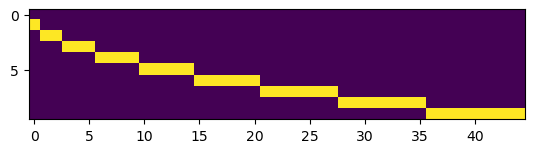

In [49]:
plt.imshow(_param_bool)
plt.show()

In [50]:
# dataset, shifts, airmass = get_dataset(file_b,[0,2,3,4,5],cpus[0])

In [51]:
# len(dataset),len(shifts)

In [52]:
# model = get_model(dataset,resolution,p_val,vel_padding,shifts,airmass,pts_per_wavelength,norm_p_val,cpus[0])

In [53]:
# model = pre_train_cycle(model, dataset, loss)

In [ ]:
for star_name,file in zip([star_name_b, star_name_p],[file_b,file_p]):
    # prerun_orders(file,star_name)
    run_orders(file   ,star_name, cpus[0],gpus[0])

2722
-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-ShiftingModel-----------------------------------------------0
  0  1-IrwinHallModel_vmap-----------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-IrwinHallModel_vmap-----------------------------------------0
  1  1-StretchingModel---------------------------------------------0
{'grad': array([0., 0., 0., ..., 0., 0., 0.]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 981, 'nit': 955, 'warnflag': 0}
{'grad': array([-9.04324276e+04,  0.00000000e+00,  7.82656596e+03, -3.47442681e+03,
       -2.06991896e+01,  1.06515006e+02,  9.53965691e+00,  1.05511419e+03,
       -2.19465647e+02,  6.88386444e+03, -5.63574862e+03,  1.41664321e+03,
        3.16958750e+02, -9.16256064e+03, -8.83626045e+03, -2.83906042e+03,
       -6.06802857e+03, -1.24910969e+03, -7.24993668e+03, -5.77476323e

5577 night sky line

In [ ]:
# modelname = 'barnardsvmapmodel1.mdl'
# # model = jabble.model.load(modelname)
# jabble.model.save(modelname,model)

In [ ]:
def make_plot(model,dataset,init_shifts,filename):
    x_window = np.log(4550) - np.log(4549)
    lmin = np.exp(dataset.xs[0,500])
    lmax = np.exp(dataset.xs[0,1500])
    lrange = np.arange(lmin,lmax,5)
    plt_unit = u.Angstrom
    epoches = 25
    r_plots = 5

    vel_epoch = 5
    fig, axes = plt.subplots(
        epoches // r_plots,
        r_plots,
        figsize=(8, 8),
        sharex=False,
        sharey=True,
        facecolor=(1, 1, 1),
        dpi=200,
    )
    # fig.suptitle(filenames[model_num])
    for plt_epoch in range((epoches // r_plots) * r_plots):
        xplot = np.linspace(np.log(lmin), np.log(lmax), dataset.xs.shape[1] * 10)
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(
            xplot.min() + model[0][0].p[plt_epoch],
            xplot.max() + model[0][0].p[plt_epoch],
        )

        # model_set[model_num].fix()
        # model_set[model_num].fit(0)
        # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),dataset.xs[plt_epoch,:],plt_epoch)
        # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])

        model.fix()

        axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(
            dataset.xs[plt_epoch, :],
            dataset.ys[plt_epoch, :],
            dataset.yerr[plt_epoch, :],
            fmt=".k",
            elinewidth=1.2,
            zorder=1,
            alpha=0.5,
            ms=3,
        )

        # true_model.fix()

        axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(
            xplot,
            model([], xplot, plt_epoch),
            "-r",
            linewidth=1.2,
            zorder=2,
            alpha=0.5,
            ms=6,
        )
        # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2, 1)
        #         axes[i,j].set_yticks([])
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(
            ["{:2.0f}".format(x) for x in lrange]
        )

        res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
        residual = loss(
            model.get_parameters(),
            dataset,
            plt_epoch,
            model,
        )
        res_ax.step(
            dataset.xs[plt_epoch, :], residual, where="mid", alpha=0.3, label="residual"
        )
        res_ax.set_ylim(0.0, 20)
        res_ax.set_yticks([])
        # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
        #             model_set[i][j].results[-2]['grad'][:],\
        #             where='mid',alpha=0.4,label='residual',zorder=-1)
        # res_ax.set_yticks([])

        # res_ax.step(x_grid,\
        #             rv_model_deriv[:,plt_epoch],\
        #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

        #     res_ax.step(x_grid,\
        #                 rv_loss_deriv[:,plt_epoch],\
        #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

        #     align_yaxis(, 0, , 0)

        align.yaxes(
            axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2.0 / 3.0
        )

    # res.get_shared_y_axes().join(ax1, ax3)
    fig.text(0.5, 0.04, "$\lambda$", ha="center")
    fig.text(0.04, 0.5, "y", va="center", rotation="vertical")
    # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
    # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
    fig.text(0.96, 0.5, "residuals", va="center", rotation=270)

    plt.savefig(
        os.path.join(out_dir, "02-res_{}.png".format(filename)),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

6563 h alpha

In [ ]:
filenames = ['51peg','barnards']
make_plot(model_b,dataset_b,shifts_b,filenames[1])

In [ ]:
def rv_plot(model_set,datasets,shift_set,filenames,file_set):
    fig, ax = plt.subplots(
        len(model_set),
        figsize=(8, 8),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True,
    )
     
    for i in range(len(model_set)):
        velocities = jabble.physics.velocities(shift_set[i]) * u.m/u.s
        epoches = datasets[i].xs.shape[0]
        epoch_range = np.arange(0, epoches, dtype=int)
        fischer_information = np.zeros(epoches)
        for e_num in range(epoches):
            model_set[i].fix()
            model_set[i].fit(0,0)
            temp = jax.jacfwd(model_set[i], argnums=0)(model_set[i].get_parameters(),datasets[i].xs[e_num,:],e_num)
            # print(temp.shape)
            fischer_information[e_num] = jnp.dot(
                temp[:, e_num] ** 2, datasets[i].yivar[e_num, :]
            )
    
        dvddx = jnp.array(
            [jax.grad(jabble.physics.velocities)(x) for x in model_set[i][0][0].p]
        )
        verr = np.sqrt(1 / fischer_information) * dvddx
        estimate_vel = jabble.physics.velocities(model_set[i][0][0].p)
        tv = velocities.to(u.m/u.s).value - velocities.to(u.m/u.s).value.mean()
        ev = estimate_vel - estimate_vel.mean()
        ax[i].errorbar(
            epoch_range,
            tv - tv,
            yerr=file_set[i]["pipeline_sigmas"][:],
            fmt=".r",
            elinewidth=2.2,
            zorder=1,
            alpha=0.5,
            ms=6,
        )
    
        ax[i].errorbar(epoch_range,tv - ev,yerr=verr,fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    
        ax[i].set_title('{}'.format(filenames[i], model_set[i][1][0].p_val))
        ax[i].set_xlim(-0.5, epoches - 0.5)
    fig.text(0.04, 0.5, "$v_{truth} - v_{est}$ [$m/s$]", va="center", rotation="vertical")
    fig.text(0.5, 0.04, "epochs", ha="center")
    plt.savefig(os.path.join(out_dir, "02-dv-barn-51peg.png"))
    plt.show()

In [ ]:
model_set = [model_p,  model_b]
datasets  = [dataset_p,dataset_b]
shift_set = [shifts_p, shifts_b]
file_set  = [file_p,   file_b]
rv_plot(model_set,datasets,shift_set,filenames,file_set)

In [ ]:
def make_better_plot(model_set,datasets,file_set):
    

    fig, axes = plt.subplots(2*len(model_set),4,figsize=(4*4,4*len(model_set)),sharex=True,facecolor=(1, 1, 1),dpi=200,height_ratios=[4,1]*len(model_set))
    
    for jj,(model,dataset,file) in enumerate(zip(model_set,datasets,file_set)):
        x_window = np.log(4550) - np.log(4549)
        lmin = np.exp(dataset.xs[0,0])
        lmax = np.exp(dataset.xs[0,2000])
        lrange = np.arange(lmin,lmax,5)
        sort_airmasses = np.argsort(np.array(file['airms'][:]))
        plt_epochs = np.concatenate((sort_airmasses[:2],sort_airmasses[-2:]))
        
        
        
        
        offset = 1.0
        xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs.shape[1]*10)
        for ii,plt_epoch in enumerate(plt_epochs):
            axes[2*jj,ii].set_xlim(xplot.min()+model[0][0].p[plt_epoch],xplot.max()+model[0][0].p[plt_epoch])
            
            model.fix()
            
            axes[2*jj,ii].errorbar(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:],\
                                     dataset.yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
            
            axes[2*jj,ii].plot(xplot,offset + model[0]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            axes[2*jj,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            axes[2*jj,ii].plot(xplot,model[2]([],xplot,plt_epoch),'-m',linewidth=1.2,zorder=3,alpha=0.7,ms=6)
            
            # axes[0,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            # axes[0,ii].plot(xplot,offset + model([],xplot,plt_epoch),'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
            
            
            axes[2*jj,ii].set_ylim(-2,3)
            axes[2*jj,ii].set_xticks([])
            # axes[0].set_yticks([])
            axes[2*jj+1,ii].set_xticks(np.log(lrange))
            axes[2*jj+1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
            
            axes[2*jj+1,ii].plot(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:] - model([],dataset.xs[plt_epoch,:],plt_epoch),'.k',alpha=0.4,ms=1)
            
            axes[2*jj+1,ii].set_ylim(-0.1,0.1)
            axes[2*jj,ii].set_title('airmass = {}'.format(file['airms'][:][plt_epoch]))
        # res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
        # residual = loss(model_set[model_num].get_parameters(),dataset,plt_epoch,model_set[model_num])
        # res_ax.step(dataset.xs[plt_epoch,:],residual,where='mid',alpha=0.3,label='residual')
        # res_ax.set_ylim(0.0,20)
        # res_ax.set_yticks([])
        # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
        #             model_set[i][j].results[-2]['grad'][:],\
        #             where='mid',alpha=0.4,label='residual',zorder=-1)
        # res_ax.set_yticks([])
        
        # res_ax.step(x_grid,\
        #             rv_model_deriv[:,plt_epoch],\
        #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
        #     res_ax.step(x_grid,\
        #                 rv_loss_deriv[:,plt_epoch],\
        #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
        #     align_yaxis(, 0, , 0)
            
            # align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)
        
        # res.get_shared_y_axes().join(ax1, ax3)
        fig.text(0.5, 0.04, '$\lambda$', ha='center')
        # fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
        # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
        # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
        # fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
    plt.savefig(os.path.join(out_dir,'02-full-barn-51peg.png'),dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
make_better_plot(model_set,datasets,file_set)

In [ ]:
file_set

In [ ]:
tell_loss = [[],[]]
for jjj, (dataset, model) in enumerate(zip(datasets,model_set)):
    for iii in range(dataset.ys.shape[0]):
        tell_loss[jjj].append(loss([],dataset,iii,model[0]).sum())

plt.plot(np.array(file_p['airms'][:]),tell_loss[0],'.k',label='51 peg')
plt.plot(np.array(file_b['airms'][:]),tell_loss[1],'.r',label='barnards')
# plt.ylim(0.0,5e4)

# plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
# plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
plt.xlabel('airmass')
plt.ylabel('$\Sigma_* (y_* - \hat{y}_s(x_*)) I_{y*}$')
# plt.plot()
plt.legend()
plt.savefig(os.path.join(out_dir,'02-airmass_loss.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
plt.xlabel('airmass')
plt.ylabel('~a')
x_space = np.linspace(np.min(np.array(file_b['airms'][:])),np.max(np.array(file_b['airms'][:])))
plt.plot(x_space,x_space,'-.k',alpha=0.3)
plt.legend()
plt.savefig(os.path.join(out_dir,'02-airmass_an.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(1,figsize=(4,4),sharex=True,facecolor=(1, 1, 1),dpi=200)

plt_epoch = 10
x_window = np.log(4550) - np.log(4549)
lmin = np.exp(dataset_p.xs[0,500])
lmax = np.exp(dataset_p.xs[0,1500])
lrange = np.arange(lmin,lmax,5)
xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset_p.xs.shape[1]*10)
axes.plot(xplot,model_p[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='51 peg')
axes.plot(xplot,0.05 + model_b[1]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='barnard')
axes.legend()

axes.set_ylim(-0.2,0.1)
axes.set_xticks([])
axes.set_ylabel('log flux + offset')
axes.set_xlabel('$\lambda$')
axes.set_xticks(np.log(lrange))
axes.set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
plt.title('just tellurics')
plt.savefig(os.path.join(out_dir,'02-airmass-tell.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# model_p.fix()
# model_p.fit(0,1)
# e_num = 0
# dudth = jax.jacfwd(model_p, argnums=0)(model_p.get_parameters(),dataset_p.xs[e_num,:],e_num)
# ith   = dudth * dataset.yivar * dudth.T
# print(dudth)

In [ ]:
def variation_info(self,model,dataset):
    f_info = np.zeros(dataset.xs.shape)
    model.fix()
    self.fit()
    for e_num in range(dataset.xs.shape[0]):
        duddx = jax.jacfwd(model, argnums=0)(model.get_parameters(),dataset.xs[e_num,:],e_num)
        f_info[e_num,:] =  jnp.dot(duddx[:,e_num]**2,dataset.yivar[e_num,:])
    return f_info